In [1]:
# GraphQL and I/O related
from pprint import pprint
from graphql_helper import run_query
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import json

# statistical analysis
import pandas as pd
# from pandas import Timestamp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math

In [2]:
uniswap_v3_subgraph_url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
refetch = False

In [3]:
TEN_LARGEST_TVL_POOLS_QUERY = """
{
    pools(first: 10, orderBy: totalValueLockedUSD, orderDirection: desc) {
        id
    } 
}
"""
if refetch:
    largest_tvl_pool_ids = run_query(uniswap_v3_subgraph_url, TEN_LARGEST_TVL_POOLS_QUERY)
    pprint(largest_tvl_pool_ids)
    largest_tvl_pool_addrs = list(map(lambda x: x["id"], largest_tvl_pool_ids["data"]["pools"]))
    largest_tvl_pool_addrs

In [4]:
GET_POOL_BY_ID_QUERY = gql(
    """
    query getPoolById($pool_addr: ID!) {
        pool(id: $pool_addr) {
            tick
            token0 {
                symbol
                id
                decimals
            }
            token1 {
                symbol
                id
                decimals
            }
            feeTier
            sqrtPrice
            liquidity
        }
    }
    """
)

In [5]:
async def fetch_pools_metadata(addresses: list, verbose: bool=False):
    result = {"topPoolDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        for id in addresses:
            params = {"pool_addr": id}
            temp = await session.execute(GET_POOL_BY_ID_QUERY, variable_values=params)
            result["topPoolDatas"].append(temp["pool"])

    if verbose:
        pprint(result)

    topPoolDatas = json.dumps(result, indent=4)
    with open('topPoolDatas.json', 'w') as file:
        file.write(topPoolDatas)

In [6]:
if refetch:
    await fetch_pools_metadata(largest_tvl_pool_addrs)

In [7]:
with open('topPoolDatas.json', 'r') as file:
    top_pool_datas = json.load(file)

token_symbols = dict()

# replace nested dict with token addr
for pool_dict in top_pool_datas["topPoolDatas"]:
    for token in ["token0", "token1"]:
        token_symbols[pool_dict[token]["id"]] = pool_dict[token]["symbol"]
        pool_dict[token] = pool_dict[token]["id"]

top_pools_df = pd.DataFrame.from_dict(top_pool_datas["topPoolDatas"]).astype({
    "token0": str,
    "token1": str,
    "feeTier": int
})
top_pools_df.drop(columns=["tick"], inplace=True)

top_pools_df.head()

,token0,token1,feeTier,sqrtPrice,liquidity
0,0x12b32f10a499bf40db334efe04226cca00bf2d9b,0x5ed60a121159481675bad3e648ba4c89753e056f,500,792049440195001924670217089101,1706245281880037395956227425
1,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,100,79229026462582839763600,3312323621734939822420234
2,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,500,79229417539107250382280,394286487035930610771435
3,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,2058484474004220286180095441299685,5870494598146803976
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,2060104979292279209990222996181970,10511597173940822220


In [8]:
top_pools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token0     10 non-null     object
 1   token1     10 non-null     object
 2   feeTier    10 non-null     int32 
 3   sqrtPrice  10 non-null     object
 4   liquidity  10 non-null     object
dtypes: int32(1), object(4)
memory usage: 488.0+ bytes


In [9]:
def poolkey2str(token0: str, token1: str, fee_tier: int) -> str:
    return token_symbols[token0] + "/" + token_symbols[token1] + "(" + str(fee_tier / 10000) + "%)"

In [10]:
pool = top_pools_df.iloc[1]
pool_name = poolkey2str(pool["token0"], pool["token1"], pool["feeTier"])

### Replicating the Info Page
We perform the following two queries over 1000 days (at most):
1. TVL
2. 24H Volume

In [11]:
POOL_CHART = gql(
    """
    query poolDayDatas($startTime: Int!, $skip: Int!, $address: String!) {
        poolDayDatas(
            first: 1000
            skip: $skip
            where: { pool: $address, date_gt: $startTime }
            orderBy: date
            orderDirection: asc
            subgraphError: allow
        ) {
            date
            volumeUSD
            tvlUSD
            feesUSD
        }
    }
    """
)

In [12]:
# ref: https://github.com/Uniswap/v3-info/blob/770a05dc1a191cf229432ebc43c1f2ceb3666e3b/src/data/pools/chartData.ts#L14
async def fetch_pool_chart_data(address: str, verbose: bool=False):
    START_TIMESTAMP = 1619170975 # GMT: Friday, April 23, 2021 9:42:55 AM
    # END_TIMESTAMP = int(time.time()) # current timestamp

    skip = 0
    all_found = False
    result = {"poolDayDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        params = {
            "address": address,
            "startTime": START_TIMESTAMP,
            "skip": skip
        }
        while not all_found:
            temp = await session.execute(POOL_CHART, variable_values=params)
            skip += 1000
            if len(temp["poolDayDatas"]) < 1000:
                all_found = True
            if temp:
                result["poolDayDatas"] = result["poolDayDatas"] + temp["poolDayDatas"] # concat the lists

    if verbose:
        pprint(result)

    poolDayDatas = json.dumps(result, indent=4)
    with open('poolDayDatas.json', 'w') as file:
        file.write(poolDayDatas)

In [13]:
pool_addr = "0x5777d92f208679db4b9778590fa3cab3ac9e2168" # DAI/USDC 0.01%
if refetch:
    await fetch_pool_chart_data(pool_addr, verbose=True)

In [14]:
# reads pool day datas from json
with open('poolDayDatas.json', 'r') as file:
    pool_day_datas = json.load(file)

# parse dict as df
df = pd.DataFrame.from_dict(pool_day_datas["poolDayDatas"]).astype({
    "volumeUSD": np.float64,
    "tvlUSD": np.float64
})

# Note: there is no need to analyze fees separately,
# as it is a fixed proportion of the pool's trade volume
df.drop(columns=["feesUSD"], inplace=True)

df.head()

,date,volumeUSD,tvlUSD
0,1636761600,4.513846e+05,1.966993e+05
1,1636848000,3.046430e+05,2.080345e+05
2,1636934400,4.836127e+05,2.080810e+05
3,1637020800,4.258826e+06,2.085063e+05
4,1637107200,4.331535e+07,7.504938e+06


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       208 non-null    int64  
 1   volumeUSD  208 non-null    float64
 2   tvlUSD     208 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 5.0 KB


In [16]:
# set column types
# ["date"]: int -> date (in "YYYY-MM-DD")
df["timestamp"] = df["date"] # keep timestamp in a new col
df["date"] = df["date"].map(dt.date.fromtimestamp)

df.head()

,date,volumeUSD,tvlUSD,timestamp
0,2021-11-13,4.513846e+05,1.966993e+05,1636761600
1,2021-11-14,3.046430e+05,2.080345e+05,1636848000
2,2021-11-15,4.836127e+05,2.080810e+05,1636934400
3,2021-11-16,4.258826e+06,2.085063e+05,1637020800
4,2021-11-17,4.331535e+07,7.504938e+06,1637107200


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       208 non-null    object 
 1   volumeUSD  208 non-null    float64
 2   tvlUSD     208 non-null    float64
 3   timestamp  208 non-null    int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 6.6+ KB


In [18]:
# sanity check for number of days elapsed
print(df["date"][0], "to", dt.date.today(), "has", (dt.date.today() - df["date"][0]))

2021-11-13 to 2022-06-13 has 212 days, 0:00:00


## 24H Volume Analysis

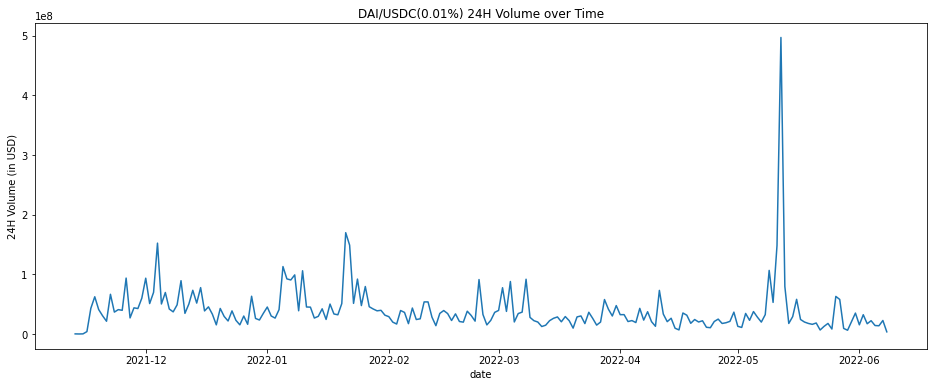

In [19]:
plt.figure(figsize=(16, 6))
plt.plot(df["date"], df["volumeUSD"])
plt.title(pool_name + " 24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.show()

In [20]:
# find the days with the greatest 24H volumes
df.sort_values(by="volumeUSD", ascending=False)[:10]

,date,volumeUSD,tvlUSD,timestamp
180,2022-05-12,4.970918e+08,3.438614e+08,1652313600
69,2022-01-21,1.700231e+08,5.269889e+07,1642723200
21,2021-12-04,1.525008e+08,4.713907e+07,1638576000
70,2022-01-22,1.491131e+08,5.272328e+07,1642809600
179,2022-05-11,1.485899e+08,3.479251e+08,1652227200
53,2022-01-05,1.132481e+08,5.766949e+07,1641340800
177,2022-05-09,1.068422e+08,3.503956e+08,1652054400
58,2022-01-10,1.062241e+08,6.030003e+07,1641772800
56,2022-01-08,9.929644e+07,6.016817e+07,1641600000
13,2021-11-26,9.393596e+07,9.234947e+06,1637884800


#### Observation
2022-05-12: Luna & UST crash

2022-01-21: (tbc)

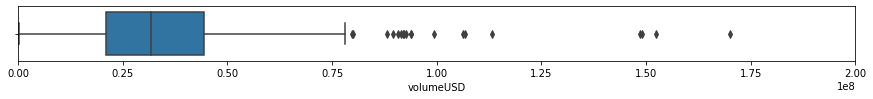

In [21]:
# for reference only, no use now
fig, ax = plt.subplots(figsize=(15, 1))
sns.boxplot(data=df, x="volumeUSD")
plt.xlim(0, 2e8)
plt.show()

### Histogram
Observe the distribution of the prices.

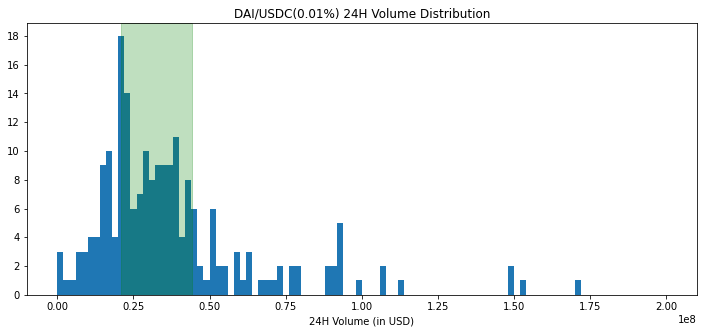

In [22]:
from matplotlib.pyplot import MaxNLocator
fig, ax = plt.subplots(figsize=(12, 5))
ax.hist(df["volumeUSD"], bins=100, range=(0, 2e8))

# force y-axis ticks to use integers
ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))
plt.title(pool_name + " 24H Volume Distribution")
plt.xlabel("24H Volume (in USD)")

# highlight 25%-75% percentile
lq = df["volumeUSD"].quantile(0.25)
uq = df["volumeUSD"].quantile(0.75)
ax.axvspan(lq, uq, color="green", alpha=0.25)

plt.show()

In [23]:
pprint({
    "mean": df["volumeUSD"].mean(),
    "median": df["volumeUSD"].median(),
    "stdev": df["volumeUSD"].std()
})

{'mean': 40325103.58612873,
 'median': 31767019.967125908,
 'stdev': 42152228.739192955}


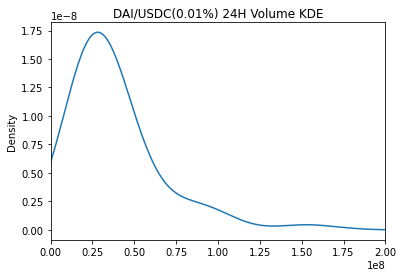

In [24]:
# for reference only, no use now
df["volumeUSD"].plot.kde()
plt.title(pool_name + " 24H Volume KDE")
plt.xlim(0, 2e8)
plt.show()

In [25]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: see if wavelet analysis is useful
# TODO: ask for calculation of Greeks (Detla, Vega...)

### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

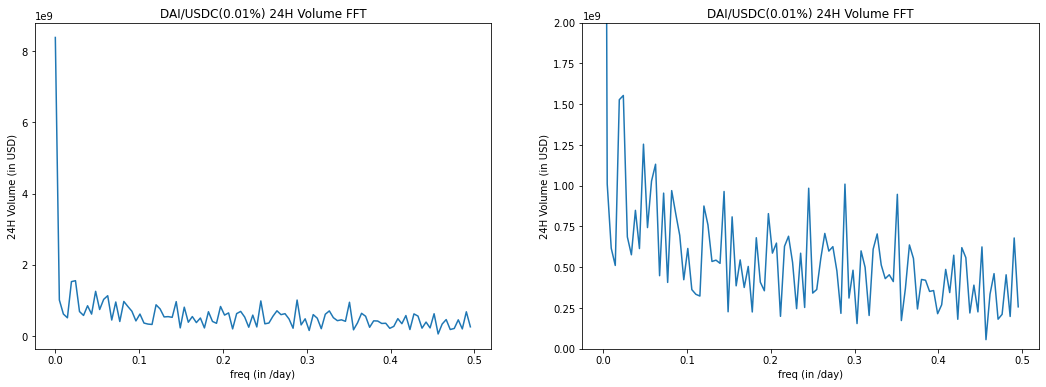

In [26]:
# only keep those with freq >= 0
Y = abs(np.fft.fft(df["volumeUSD"]))[0:math.ceil(df.shape[0]/2)]
freq = np.fft.fftfreq(df.shape[0], 1)[0:math.ceil(df.shape[0]/2)]

# plot the pool data
fig, ax = plt.subplots(figsize=(18, 6))

# plot 1: 24H volume
plt.subplot(1, 2, 1)
plt.plot(freq, Y)
plt.title(pool_name + " 24H Volume FFT")
plt.xlabel("freq (in /day)")
plt.ylabel("24H Volume (in USD)")

# plot 2: TVL
plt.subplot(1, 2, 2)
plt.plot(freq, Y)
plt.ylim(0, 2e9)
plt.title(pool_name + " 24H Volume FFT")
plt.xlabel("freq (in /day)")
plt.ylabel("24H Volume (in USD)")

plt.show()

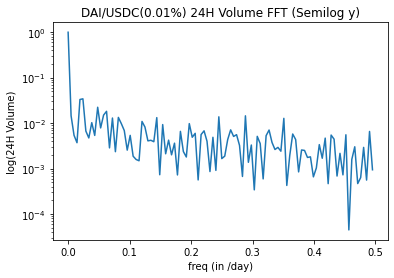

In [27]:
# get the list of spectrums
spectrum = Y.real*Y.real + Y.imag*Y.imag
nspectrum = spectrum / spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq, nspectrum)
plt.title(pool_name + " 24H Volume FFT (Semilog y)")
plt.xlabel("freq (in /day)")
plt.ylabel("log(24H Volume)")
plt.show()

## TVL Analysis

In [28]:
import pwlf_helper
reg_result = pwlf_helper.regression(df["timestamp"], df["tvlUSD"], 6)

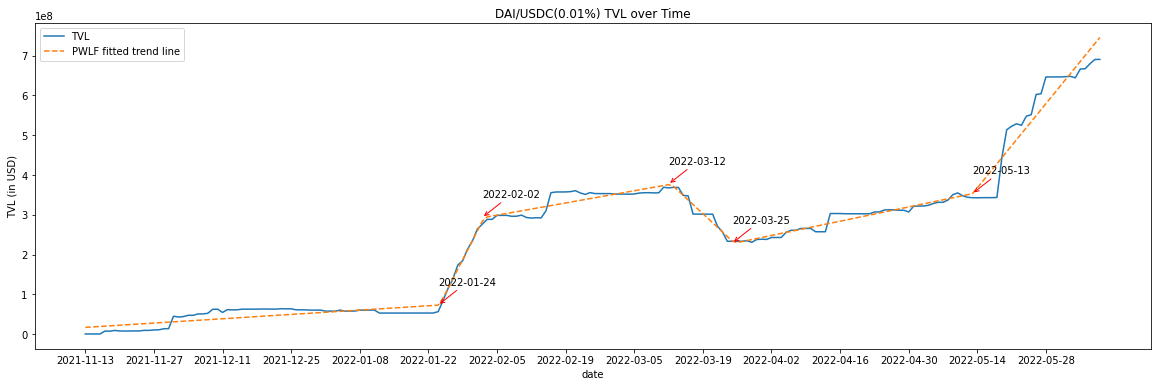

In [29]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(df["date"], df["tvlUSD"])
plt.plot(df["date"], reg_result.yHat, '--')

plt.title(pool_name + " TVL over Time")
plt.xlabel("date")
plt.ylabel("TVL (in USD)")
plt.legend(["TVL", "PWLF fitted trend line"])

# x-axis ticks are spaced out biweekly (for now)
plt.xticks(pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], freq="14D"))

# annotate turning points
for tp in reg_result.tp[1:-1]:
    tp_date = dt.date.fromtimestamp(tp)
    tp_str = tp_date.strftime("%Y-%m-%d")
    pred = reg_result.predict(tp)
    ax.annotate(tp_str, xy=(tp_date, pred), xytext=(tp_date, pred+0.5e8),
        arrowprops=dict(arrowstyle="->", color='red')
    )

plt.show()